# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import numpy as np
from glob import glob

# local data paths
#dogs_dir = os.path.join('..', '..', '..', 'Data','dogs')
#lfw_dir = os.path.join('..', '..', '..', 'Data','lfw')

# online data paths
dogs_dir = os.path.join(os.sep, 'data', 'dog_images')
lfw_dir = os.path.join(os.sep, 'data', 'lfw')

# load filenames for human and dog images
human_files = np.array(glob(os.path.join(lfw_dir, '*', '*')))
dog_files = np.array(glob(os.path.join(dogs_dir, '*', '*', '*')))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


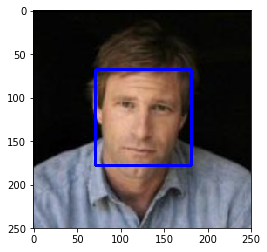

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm
## on the images in human_files_short and dog_files_short.

# initialize auxiliar variables
true_positives, false_positives = 0, 0

# evaluate the face detector with images from both databases
for human_image, dog_image in zip(human_files_short, dog_files_short):

    # accumulate face detections in human images
    if face_detector(human_image):
        true_positives += 1

    # accumulate face detections in dog images
    if face_detector(dog_image):
        false_positives += 1

# display the evaluation results
print('Human faces are detected in human images {}% of the time'.format(true_positives/len(human_files_short)*100))
print('Human faces are detected in dog images {}% of the time'.format(false_positives/len(dog_files_short)*100))

Human faces are detected in human images 96.0% of the time
Human faces are detected in dog images 18.0% of the time


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional)
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# random seed PyTorch
torch.manual_seed(42)

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
def generate_processing_pipeline(use_augmentation, normalization):
    """
    Generates a pipeline of image transformations for PyTorch model zoo

    Parameters
    ----------
    use_augmentation : bool
        True  uses extra transformations for data augmentation
        False otherwise
    normalization : torchvision.transforms.Normalize
        The approach to data normalization

    Returns
    -------
    torchvision.transforms.Compose
        The resulting pipeline of image transformations
    """

    # define the image processing pipeline
    pipeline = list()

    # rescale the image to ensure better crops
    pipeline.append(transforms.Resize(256))

    # crop the image and append data augmentation transformations if selected
    if use_augmentation:
        pipeline.append(transforms.RandomCrop(224))
        pipeline.append(transforms.RandomHorizontalFlip(0.5))

    else:
        pipeline.append(transforms.CenterCrop(224))

    # normalize the images
    pipeline.append(transforms.ToTensor())
    pipeline.append(normalization)

    # return the image processing pipeline
    return transforms.Compose(pipeline)

In [8]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.autograd import Variable
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to
    predicted ImageNet class for image at specified path

    Args:
        img_path: path to an image

    Returns:
        Index corresponding to VGG-16 model's prediction
    '''

    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    # define image normalization according to PyTorch model zoo
    zoo_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # generate the image processing pipeline according to the pre-trained model requirements
    processing_pipeline = generate_processing_pipeline(False, zoo_normalization)

    # generate the test data based on the image path
    img_raw = Image.open(img_path)
    img_pro = processing_pipeline(img_raw)
    img_var = Variable(img_pro.unsqueeze_(0))

    # move data to GPU if CUDA is available
    if use_cuda:
        img_var = img_var.cuda()

    # classify the processed image
    with torch.no_grad():

        VGG16.eval()
        result = VGG16(img_var)

        # move results to CPU if CUDA is available
        if use_cuda:
            result = result.cpu()

    # return the index of the class with highest probability
    return result.data.numpy().argmax()

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    return VGG16_predict(img_path) in np.arange(151, 269)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# initialize auxiliar variables
true_positives, false_positives = 0, 0

# evaluate the dog detector with images from both databases
for human_image, dog_image in zip(human_files_short, dog_files_short):

    # accumulate dog detections in dog images
    if dog_detector(dog_image):
        true_positives += 1

    # accumulate dog detections in dog images
    if dog_detector(human_image):
        false_positives += 1

# display the evaluation results
print('Dogs are detected in dog images {}% of the time'.format(true_positives/len(human_files_short)*100))
print('Dogs are detected in human images {}% of the time'.format(false_positives/len(dog_files_short)*100))

Dogs are detected in dog images 94.0% of the time
Dogs are detected in human images 0.0% of the time


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional)
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
def generate_data_loader(data_path, normalization, train_mode, batch_size, num_workers=0):
    """
    Generates a dataset iterator with processed images and ground truth based on the given path

    Parameters
    ----------
    data_path : str
        The path to the dataset with images sorted in folders according to their class
    normalization : torchvision.transforms.Normalize
        The approach to data normalization
    train_mode : bool
        True  uses data augmentation for the image processing pipeline
        False otherwise
    batch_size : int
        The amount of samples in a batch generated by the dataset iterator
    num_workers : int
        The amount of sub-processes used for data loading (e.g., 0 means the data is loaded in the main process)

    Returns
    -------
    torch.utils.data.DataLoader
        The generated dataset iterator
    """

    # create the dataset
    dataset = datasets.ImageFolder(data_path, transform=generate_processing_pipeline(train_mode, normalization))

    # define the batch size
    if len(dataset) > batch_size:
        batch_size = batch_size

    else:
        batch_size = len(dataset)

    # create the dataset iterator
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # return the dataset iterator
    return dataloader

In [13]:
def generate_data_loaders(data_path, use_zoo_normalization=True, batch_size=32, valid_size=0.2, num_workers=0):
    """
    Generates a training, validation, and test dataset iterators from a database path

    Parameters
    ----------
    data_path : str
        The path to the database with the following folder structure
            - train [required]
                * class
                ...
            - valid [optional]
                * class
                ...
            - test [required]
                * class
                ...
    use_zoo_normalization : bool
        True  applies data normalization approach used by PyTorch model zoo
        False applies data normalization with zero mean and unit standard deviation
    batch_size : int
        The amount of samples in a batch generated by the training dataset iterator
    valid_size : float
        The percentage of training samples used by the validation dataset iterator
        This variable is only used when the database has no valid folder structure
    num_workers : int
        The amount of sub-processes used for data loading (e.g., 0 means the data is loaded in the main process)

    Returns
    -------
    dict
        A dictionary containing the generated dataset iterators
            - {'train':dataloader, 'valid':dataloader, 'test':dataloader}
    """

    # define the paths to the image folders
    train_path = os.path.join(data_path, 'train')
    valid_path = os.path.join(data_path, 'valid')
    test_path = os.path.join(data_path, 'test')

    # ensure the required folders exist
    assert (os.path.exists(train_path) and os.path.exists(test_path))

    # define the approach to data normalization
    if use_zoo_normalization:
        normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    else:
        normalization = transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])

    # generate training and validation dataset iterators
    if not os.path.exists(valid_path):

        # create the training dataset
        # note: augmentation is disabled to prevent validation images too similar to training ones
        train_dataset = datasets.ImageFolder(data_path, transform=generate_processing_pipeline(False, normalization))

        # obtain training indices that will be used for validation
        num_train = len(train_dataset)
        indices = list(range(num_train))
        np.random.shuffle(indices)
        split = int(np.floor(valid_size * num_train))
        train_idx, valid_idx = indices[split:], indices[:split]

        # define samplers for obtaining training and validation batches
        train_sampler = data.sampler.SubsetRandomSampler(train_idx)
        valid_sampler = data.sampler.SubsetRandomSampler(valid_idx)

        # prepare data loaders (combine dataset and sampler)
        tr_dl = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
        va_dl = data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

    else:

        tr_dl = generate_data_loader(train_path, normalization, True, batch_size)
        va_dl = generate_data_loader(valid_path, normalization, False, batch_size)

    # generate the test dataset iterator
    te_dl = generate_data_loader(test_path, normalization, False, batch_size)

    # return the dictionary of dataloaders
    return {'train': tr_dl, 'valid': va_dl, 'test': te_dl}

In [14]:
from torchvision import datasets
from torch.utils import data

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# generate the training, validation, and test dataset iterators
loaders_scratch = generate_data_loaders(data_path=dogs_dir, use_zoo_normalization=False)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

* In all datasets, the images are transformed with **torchvisions.transforms.Resize($256$)** that matches the smaller edge of the image to $256$ pixels and rescales the other edge to $256 *$**height**$/$**width** pixels in order to increase the chance to have better crops to $224x224$ pixels.
* In the case of the training dataset, the images are cropped to $224x224$ pixels and augmented using **torchvisions.transforms.RandomCrop($224$)** in combination with **transforms.RandomHorizontalFlip($0.5$)**, which randomly flips them horizontally with $0.5$ probability.
* In the case of the validation and test dataset, the images are center cropped to $224x224$ pixels using **torchvisions.transforms.CenterCrop($224$)** without augmentation to preserve their original characteristics as much as possible.
* In all datasets, the images are either normalized with zero mean and unit standard deviation, or according to the values used by Torchvision.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    def __init__(self, num_classes=133):
        # initialize parent class variables
        super(Net, self).__init__()
        # define the feature extractor backbone
        self.features = nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(8),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(16),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2))

        # define the feature classifier
        self.classifier = nn.Sequential(nn.Linear(64*14*14, 1024),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5),
                                        nn.Linear(1024, num_classes),
                                        nn.LogSoftmax(dim=1))

    def forward(self, x):
        # extract features
        x = self.features(x)
        # flatten features
        x = x.view(x.size()[0], -1)
        # classify features
        x = self.classifier(x)

        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-0

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ This custom model is inspired by [VGG16](http://arxiv.org/abs/1409.1556/), which has a simple architecture and attained very good performance for object recognition tasks in the [ILSVRC2014](http://www.image-net.org/challenges/LSVRC/2014/). Since the dog dataset is more constraint than [ImageNet](http://www.image-net.org/), its architecture is shallower with a reduced number of filters in the convolutional blocks and less neurons in the fully connected layers. It combines two deep neural networks: *features* and *classifier*. The former comprises four convolutional blocks of one layer activated with ReLU and followed by Maxpool. The latter has two fully connected layers activated with ReLU and LogSoftmax respectively.

In-line with VGG architectures found in literature, this custom model implements regularization using [Dropout](http://jmlr.org/papers/v15/srivastava14a.html) between fully connected layers of the *classifier* network. In addition, it uses [Batch Normalization](http://arxiv.org/abs/1502.03167/) in the convolutional blocks to mitigate the effect of covariance shift and to introduce a slight regularization effect between the layers of the *features* network. The weights of both the convolutional and fully connected layers are initialized according to [Xavier](http://proceedings.mlr.press/v9/glorot10a.html) and the biases of the fully connected layers are set to a small arbitrary value close to zero.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [16]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [17]:
def initialize_xavier(module):
    """
    Initializes convolutional and linear module weights according to
    `Xavier <http://pytorch.org/docs/stable/nn.html#torch.nn.init.xavier_uniform_>`_
    and sets biases to an arbitrary small value close to zero

    Parameters
    ----------
    module : torch.nn.Module
        The PyTorch module (e.g., torch.nn.Linear)
    """

    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)

        if isinstance(module, torch.nn.Linear):
            module.bias.data.fill_(0.01)

In [18]:
def save(model, filename):
    """
    Saves the parameter dictionary of a PyTorch model

    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to save
    filename : str
        The filename of the model's parameter dictionary
    """

    torch.save(model.state_dict(), filename)

In [19]:
def load(model, filename):
    """
    Loads a parameter dictionary into a PyTorch model

    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to restore
    filename : str
        The filename of the model's parameter dictionary
    """

    state_dict = torch.load(filename)
    model.load_state_dict(state_dict)

In [20]:
def train(epochs, loaders, model, optimizer, criterion, device, save_path='trained_model.pth', verbose=False):
    """
    Trains and validates a PyTorch model

    Parameters
    ----------
    epochs : int
        The number of epochs used to train and validate the model
    loaders : dict
        A dictionary comprising 'train' and 'valid' torch.utils.data.DataLoader
    model : torch.nn.Module
        The PyTorch model to train and validate
    optimizer : torch.optim.Optimizer
        The approach to optimize the model parameters
    criterion : torch.nn.Criterion
        The approach to measure the model loss during training and validation
    device : str
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation
    save_path : str
        The filename for the best performing model parameter dictionary
    verbose : bool
        True  displays train and validation losses in each epoch
        False silent mode

    Returns
    -------
    numpy.ndarray
        The recorded training loss for each epoch
    numpy.ndarray
        The recorded validation loss for each epoch
    """

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    # initialize variables to monitor training and validation loss
    train_losses, valid_losses = torch.zeros(epochs), torch.zeros(epochs)

    # move model to GPU if CUDA implementation is selected
    model = model.to(device)

    for epoch in np.arange(epochs):

        ###################
        # train the model #
        ###################

        # set-up the training mode and wipe gradients
        model.train()

        # iterate over the training samples
        for batch_idx, (data, target) in enumerate(loaders['train']):

            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # record the training loss
            train_losses[epoch] += loss.item() * data.size(0)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

        ######################
        # validate the model #
        ######################

        # set-up validation mode
        model.eval()

        with torch.no_grad():

            # iterate over the validation samples
            for batch_idx, (data, target) in enumerate(loaders['valid']):

                # move tensors to GPU if CUDA is available
                data, target = data.to(device), target.to(device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # calculate the batch loss
                loss = criterion(output, target)

                # record the validation loss
                valid_losses[epoch] += loss.item() * data.size(0)

        # calculate average train and validation loss
        train_losses[epoch] /= len(loaders['train'].dataset)
        valid_losses[epoch] /= len(loaders['valid'].dataset)

        # print training/validation statistics
        if verbose:
            log_text = 'Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'
            print(log_text.format(epoch, train_losses[epoch], valid_losses[epoch]))

        # save the model if validation loss has decreased
        if valid_losses[epoch] < valid_loss_min:
            valid_loss_min = valid_losses[epoch]
            save(model, save_path)

    # load the best model
    load(model, save_path)

    # return train and validation losses
    return train_losses.cpu().numpy(), valid_losses.cpu().numpy()

In [21]:
# initialize the weights and biases
model_scratch.apply(initialize_xavier)

# train the model
train_losses, valid_losses = train(250, loaders_scratch, model_scratch, optimizer_scratch,
                                   criterion_scratch, device, 'model_scratch.pt', True)

Epoch: 0 	Training Loss: 5.2734 	Validation Loss: 4.8046
Epoch: 1 	Training Loss: 4.8020 	Validation Loss: 4.6593
Epoch: 2 	Training Loss: 4.7424 	Validation Loss: 4.6259
Epoch: 3 	Training Loss: 4.7033 	Validation Loss: 4.5599
Epoch: 4 	Training Loss: 4.6897 	Validation Loss: 4.6001
Epoch: 5 	Training Loss: 4.6787 	Validation Loss: 4.5417
Epoch: 6 	Training Loss: 4.6809 	Validation Loss: 4.5860
Epoch: 7 	Training Loss: 4.6773 	Validation Loss: 4.5025
Epoch: 8 	Training Loss: 4.6620 	Validation Loss: 4.5567
Epoch: 9 	Training Loss: 4.6595 	Validation Loss: 4.5206
Epoch: 10 	Training Loss: 4.6484 	Validation Loss: 4.4967
Epoch: 11 	Training Loss: 4.6466 	Validation Loss: 4.5028
Epoch: 12 	Training Loss: 4.6557 	Validation Loss: 4.5059
Epoch: 13 	Training Loss: 4.6474 	Validation Loss: 4.4457
Epoch: 14 	Training Loss: 4.6528 	Validation Loss: 4.5006
Epoch: 15 	Training Loss: 4.6314 	Validation Loss: 4.4758
Epoch: 16 	Training Loss: 4.6268 	Validation Loss: 4.4657
Epoch: 17 	Training Loss

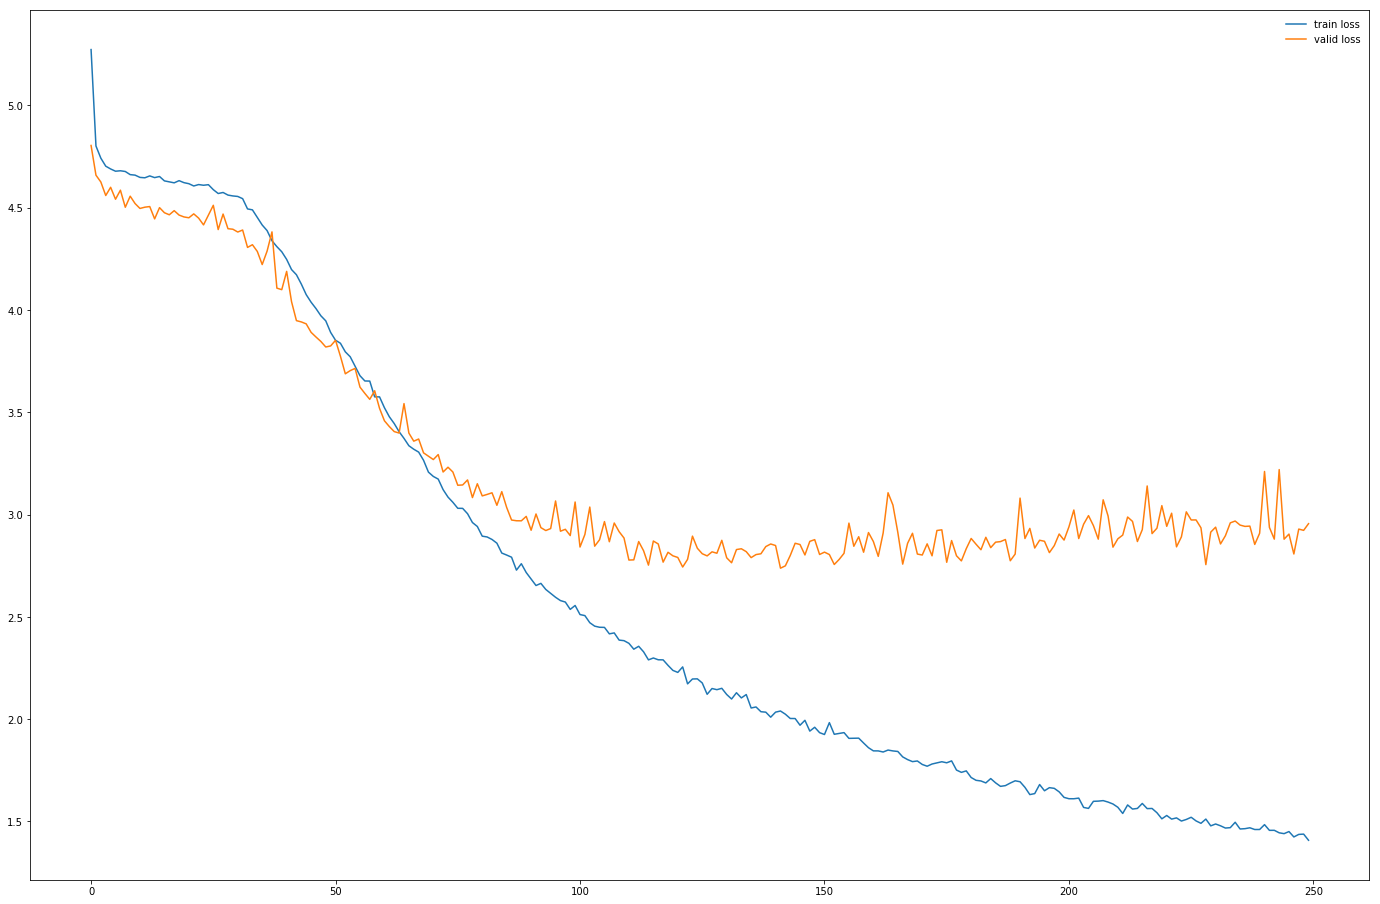

In [22]:
# plot the training and validation losses
plt.figure(figsize=(24, 16))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend(frameon=False)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [23]:
def test_top_one(loaders, model, num_classes, device, verbose=False):
    """
    Evaluates the top-1 classification accuracy of a PyTorch model

    Parameters
    ----------
    loaders : dict
        A dictionary comprising 'test' torch.utils.data.DataLoader
    model : torch.nn.Module
        The PyTorch model to test
    num_classes : int
        The number of classes recognized by the PyTorch model
    device : str
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation
    verbose : bool
        True  displays the mean top-1 classification accuracy
        False silent mode

    Returns
    -------
    float
        The mean top-1 classification accuracy of the model
    numpy.ndarray
        The confusion matrix of the predicted and target classes
    """

    # initialize test variables
    correct, total = 0, 0
    confusion_matrix = torch.zeros(num_classes, num_classes)

    # set-up model for evaluation
    model.eval()

    # move model to GPU if CUDA is available
    model = model.to(device)

    with torch.no_grad():

        # iterate over the test samples
        for _, (inputs, targets) in enumerate(loaders['test']):

            # move tensors to GPU if CUDA is available
            inputs, targets = inputs.to(device), targets.to(device)

            # infer the top-1 image labels
            outputs = torch.exp(model(inputs))
            prediction = outputs.data.max(1, keepdim=True)[1]

            # accumulate correct and total predictions
            correct += torch.sum(torch.squeeze(prediction.eq(targets.data.view_as(prediction))))
            total += inputs.size(0)

            for t, p in zip(targets.view(-1), prediction.view(-1)):

                # register predictions in the confusion matrix
                confusion_matrix[t.long(), p.long()] += 1

    # calculate the mean top-1 accuracy
    confusion_matrix = confusion_matrix.cpu().numpy()
    accuracy = correct.cpu().numpy() / total

    if verbose:
        print('Model Accuracy: {:.2f}'.format(accuracy))

    return accuracy, confusion_matrix

In [24]:
# calculate the model accuracy
accuracy, matrix = test_top_one(loaders_scratch, model_scratch, 133, device, True)

Model Accuracy: 0.34


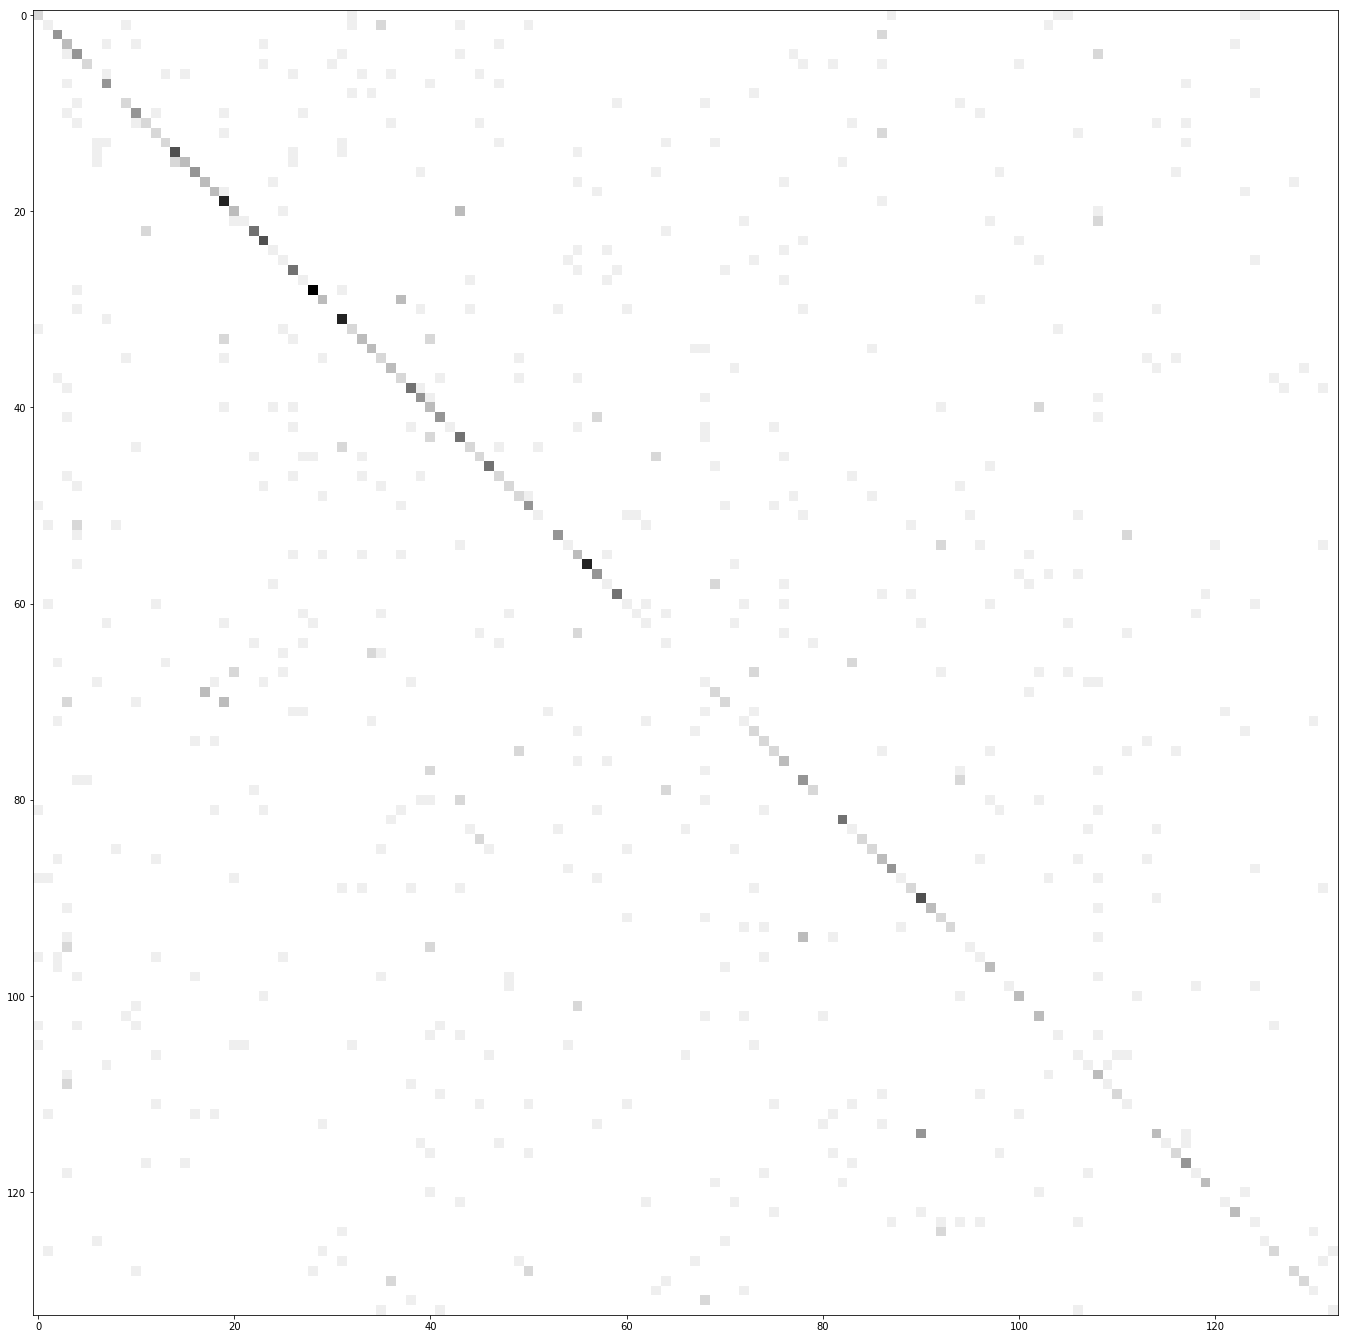

In [25]:
# plot the confusion matrix
plt.figure(figsize=(24, 24))
plt.imshow(matrix, cmap='Greys', interpolation='nearest')

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [26]:
## TODO: Specify data loaders
loaders_transfer = generate_data_loaders(data_path=dogs_dir, use_zoo_normalization=True)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture

# load the pre-trained model
model_transfer = models.densenet161(pretrained=True)

# freeze parameters from the pre-trained model
for param in model_transfer.parameters():
    param.requires_grad = False

# replace the classifier network of the pre-trained model
classifier = nn.Sequential(nn.Linear(2208, 1024),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(1024, 133),
                           nn.LogSoftmax(dim=1))

model_transfer.classifier = classifier
print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

C:\ProgramData\Anaconda3\envs\torchdnn\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Initially, I checked [Torchvision](http://pytorch.org/docs/stable/torchvision/models.html) to know which pre-trained models are available in PyTorch and their reported performance. I selected [ResNet-152](http://arxiv.org/abs/1512.03385), [DenseNet-161](http://arxiv.org/abs/1608.06993), and [Inception-v3](http://arxiv.org/abs/1512.00567) as candidate architectures based on their model's top-1 and top-5 errors. Unfortunately, the site does not report run-time, but only accuracy, so I turn to academic literature looking for a relevant [benchmark](http://arxiv.org/abs/1810.00736) in order to make the final decision among the candidate architectures. The published run-time results on multiple platforms clearly favor DenseNet-161. Nonetheless, I queried main-stream literature to validate my selection and learn from the [experience](http://www.jeremyjordan.me/convnet-architectures) of other machine learning professionals. I concluded that the architecture of DenseNet-161 leads to models with the most promising performance. Finally, I replaced the classifier network from the pre-trained PyTorch model using the one proposed for the custom model's architecture.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [28]:
criterion_transfer = nn.NLLLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [29]:
# fine-tune the pre-trained model
train_losses, valid_losses = train(25, loaders_transfer, model_transfer, optimizer_transfer,
                                   criterion_transfer, device, 'model_transfer.pt', True)

Epoch: 0 	Training Loss: 2.4159 	Validation Loss: 0.7257
Epoch: 1 	Training Loss: 0.8870 	Validation Loss: 0.4997
Epoch: 2 	Training Loss: 0.6915 	Validation Loss: 0.4296
Epoch: 3 	Training Loss: 0.5992 	Validation Loss: 0.3932
Epoch: 4 	Training Loss: 0.5472 	Validation Loss: 0.3799
Epoch: 5 	Training Loss: 0.5029 	Validation Loss: 0.3885
Epoch: 6 	Training Loss: 0.5102 	Validation Loss: 0.3493
Epoch: 7 	Training Loss: 0.4626 	Validation Loss: 0.3572
Epoch: 8 	Training Loss: 0.4325 	Validation Loss: 0.3384
Epoch: 9 	Training Loss: 0.4097 	Validation Loss: 0.3884
Epoch: 10 	Training Loss: 0.3990 	Validation Loss: 0.3697
Epoch: 11 	Training Loss: 0.3955 	Validation Loss: 0.3678
Epoch: 12 	Training Loss: 0.3731 	Validation Loss: 0.3749
Epoch: 13 	Training Loss: 0.3583 	Validation Loss: 0.3863
Epoch: 14 	Training Loss: 0.3535 	Validation Loss: 0.3707
Epoch: 15 	Training Loss: 0.3694 	Validation Loss: 0.3366
Epoch: 16 	Training Loss: 0.3366 	Validation Loss: 0.3554
Epoch: 17 	Training Loss

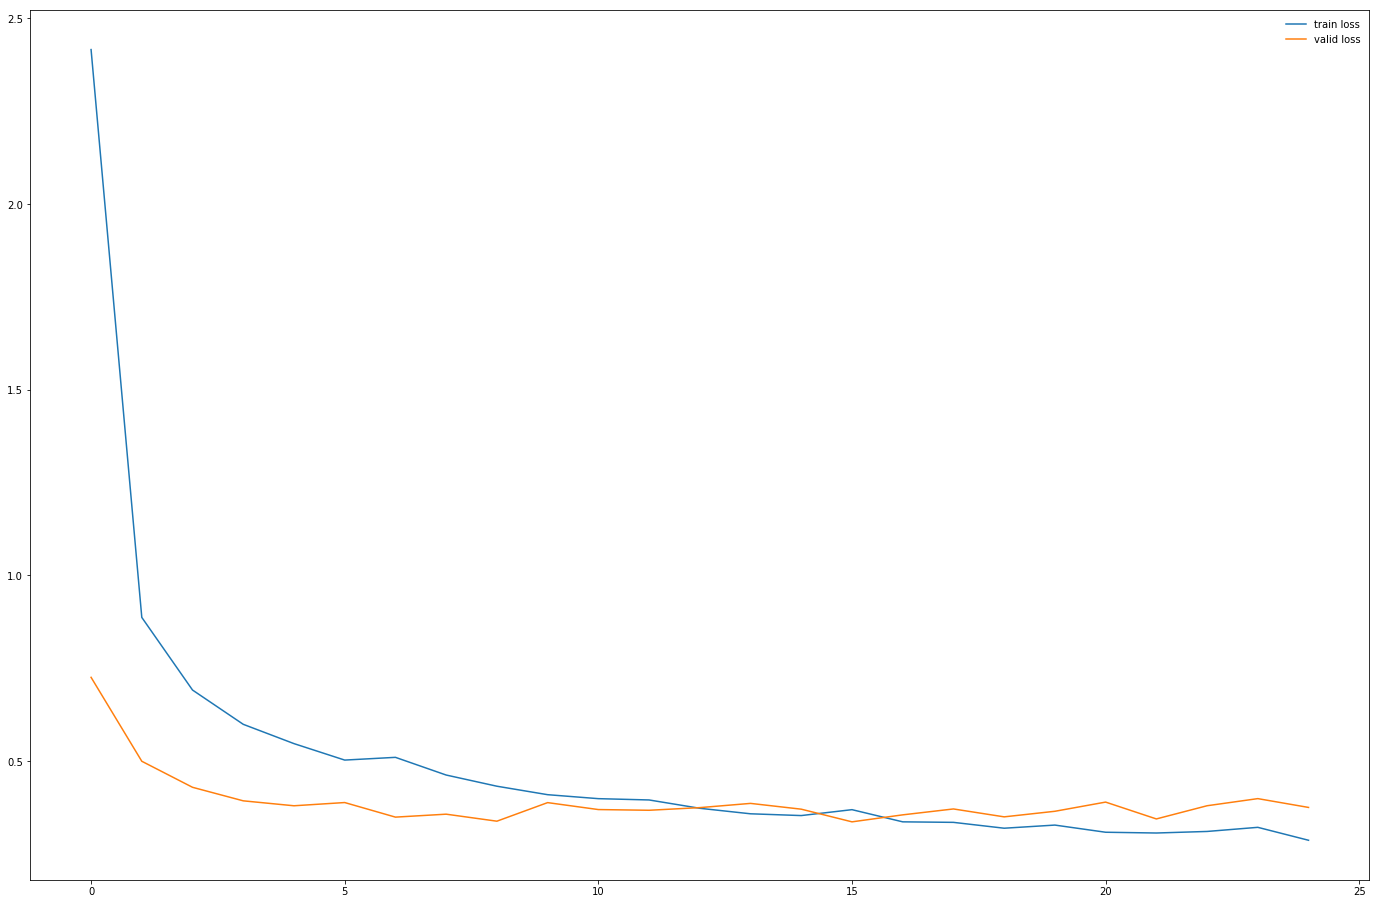

In [30]:
# plot the training and validation losses
plt.figure(figsize=(24, 16))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend(frameon=False)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [31]:
# calculate the fine-tuned model accuracy
accuracy, matrix = test_top_one(loaders_transfer, model_transfer, 133, device, True)

Model Accuracy: 0.89


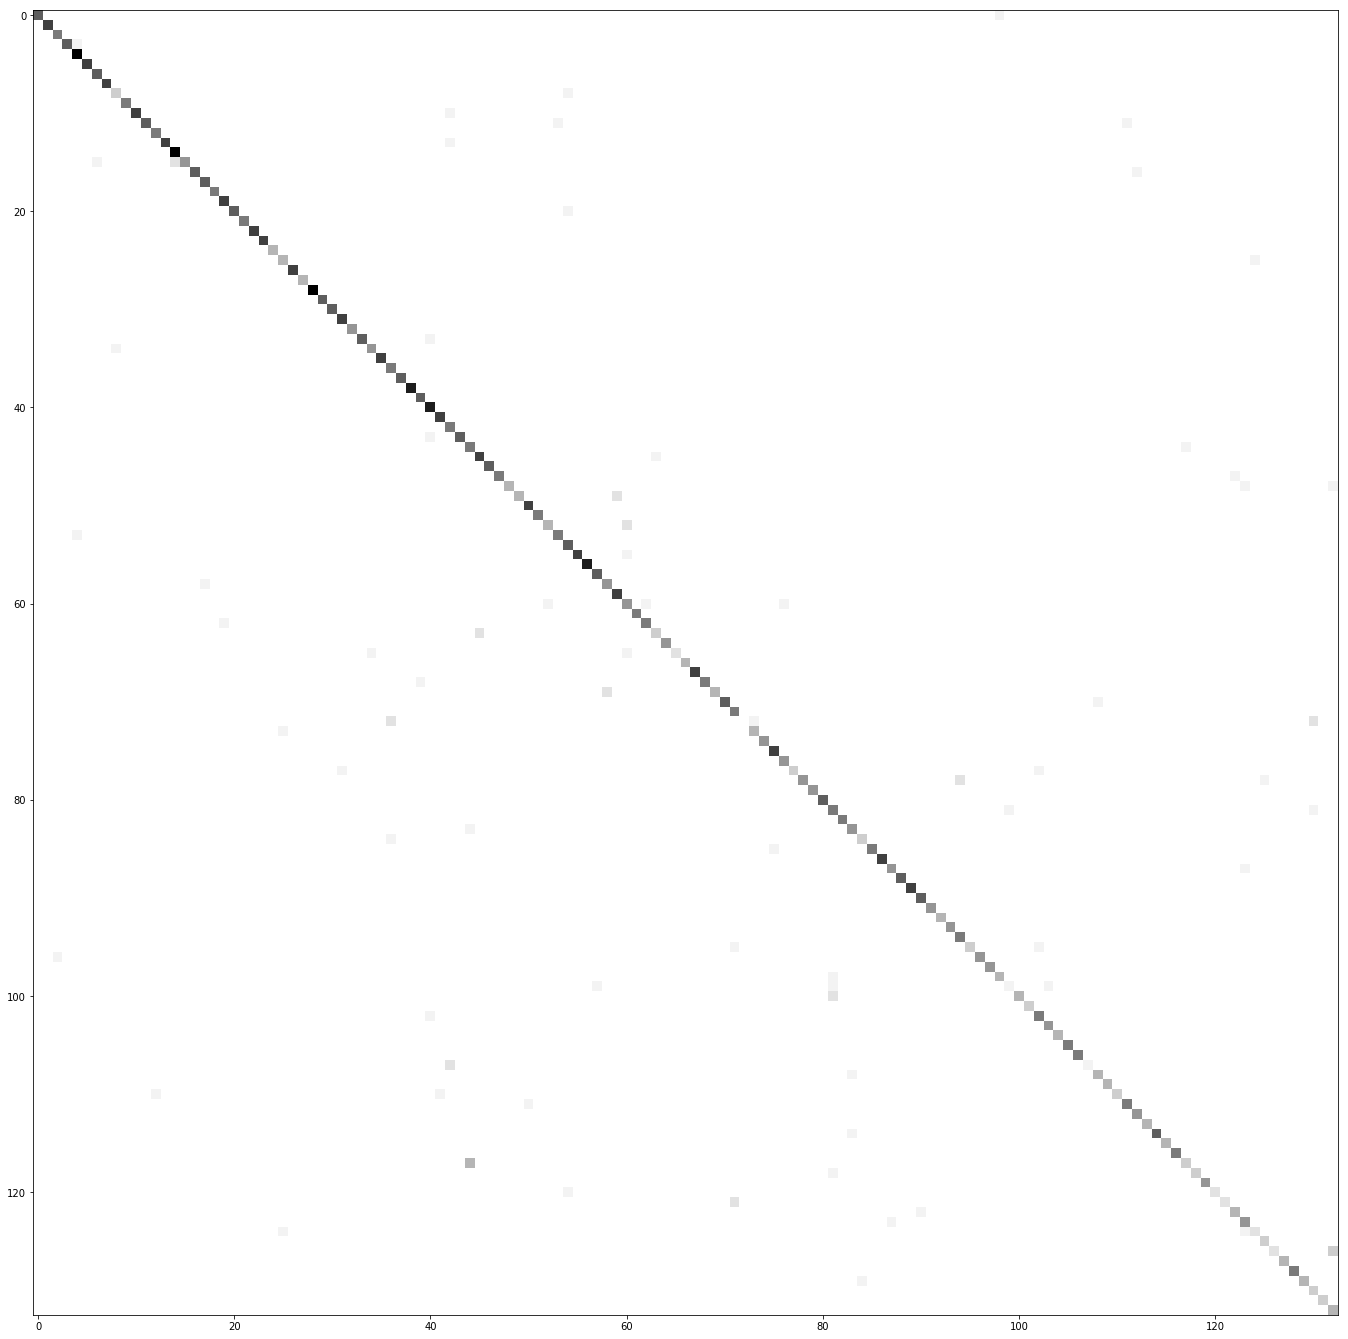

In [32]:
# plot the confusion matrix
plt.figure(figsize=(24, 24))
plt.imshow(matrix, cmap='Greys', interpolation='nearest')

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [33]:
def process_image(image_path, use_zoo_normalization=True):
    """
    Transforms the image according to the processing pipeline

    Parameters
    ----------
    image_path : str
        The path to the image
    use_zoo_normalization : bool
        True  applies data normalization approach used by PyTorch model zoo
        False applies data normalization with zero mean and unit standard deviation

    Returns
    -------
    torch.autograd.Variable
        The processed image
    """

    # define the approach to data normalization
    if use_zoo_normalization:
        normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    else:
        normalization = transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])

    # define the image processing pipeline
    processing_pipeline = generate_processing_pipeline(False, normalization)

    # load and process the image
    image_raw = Image.open(image_path)
    image_pro = processing_pipeline(image_raw)

    # create a tensor with the processed image
    image_var = torch.autograd.Variable(image_pro.unsqueeze_(0))

    return image_var

In [34]:
def classify(image_var, model, device):
    """
    Predicts the top-1 class of an image with the given PyTorch model

    Parameters
    ----------
    image_var : torch.autograd.Variable
        The processed image
    model : torch.nn.Module
        The PyTorch model
    device : str
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation

    Returns
    -------
        The top-1 class prediction
    """

    # move model to GPU if CUDA is available
    model = model.to(device)
    image = image_var.to(device)

    # classify the image
    with torch.no_grad():

        model.eval()
        prediction = torch.exp(model(image))

    return prediction.cpu().data.numpy().argmax()

In [35]:
def predict_breed_transfer(image_path, label_types, model, device):
    """
    Predicts the top-1 class name of an image with the given PyTorch model    

    Parameters
    ----------
    image_path : str
        The path to the image
    label_types : list
        The keywords to decode the labels
    model : torch.nn.Module
        The PyTorch model
    device : str
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation

    Returns
    -------
    str
        The keyword of the top-1 predicted label
    """

    # load the image and return the predicted breed
    image_var = process_image(image_path, True)
    label_pre = classify(image_var, model, device)

    return label_types[label_pre]

In [36]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

import random

# build the label types
label_types = next(os.walk(os.path.join(dogs_dir, 'test')))[1]

# select the test image
label_test = random.choice(label_types)
root_dir = os.path.join(dogs_dir, 'test', label_test)
image_names = next(os.walk(root_dir))[2]
image_name = random.choice(image_names)
image_path = os.path.join(root_dir, image_name)

# predict the dog breed
label_pre = predict_breed_transfer(image_path, label_types, model_transfer, device)
print('Prediction: {} ({})'.format(label_pre[4:].replace('_', ' '), label_pre == label_test))

Prediction: Glen of imaal terrier (True)


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [37]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(image_path, label_types, model_transfer, device):
    """
    Determines whether an image contains a dog, a human, or neither

    Parameters
    ----------
    image_path : str
        The path to the image
    label_types : list
        The keywords to decode the labels
    model : torch.nn.Module
        The PyTorch model
    device : str
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation

    Returns
    -------
    str
        The predicted dog breed if the image has a dog
        The resembled dog breed if the image has no dog and a human
        Error message otherwise
    """

    # it's a dog
    if dog_detector(image_path) > 0:
        label_pre = predict_breed_transfer(image_path, label_types, model_transfer, device)
        label_mes = '{} ({})'.format('Dog', label_pre[4:].replace('_', ' '))

    # it's a human
    elif face_detector(image_path) > 0:
        label_pre = predict_breed_transfer(image_path, label_types, model_transfer, device)
        label_mes = '{} (looks like: {})'.format('Human', label_pre[4:].replace('_', ' '))

    # it's neither a dog nor a human
    else:
        label_mes = 'Error: Unknown!'

    return label_mes

In [38]:
def display_image_grid(images, labels, fig_shape, fig_size=(25, 4)):
    """
    Plots images with their corresponding labels in a figure

    Parameters
    ----------
    images : list
        The images to plot in the figure
    labels : list
        The encoded labels of the images
    fig_shape : tuple
        The number of rows and columns of the figure
    fig_size : tuple
        The width and height of the figure
    """

    fig = plt.figure(figsize=fig_size)
    rows, cols = fig_shape

    for idx in np.arange(rows*cols):

        ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
        ax.set_title(labels[idx], color=('red' if 'Error' in labels[idx] else 'black'))
        plt.imshow(images[idx])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The algorithm matches my expectations. During this project, I identified the following improvement opportunities for further research and development:

* Provide a more accurate feedback by including the confidence of object detection and classification.
* Classify objects based on the pixels from their RoI instead of using the pixels from the whole image.
* Simultaneously detect and classify multiple object instances in the image.
* Increase the number of supported higher level categories (e.g., dogs, cats, humans, etc).
* Use a fully convolutional classifier network defined through a more exhaustive search of hyper-parameters.
* Fine-tune more architectures available in literature and select the best performing one with comprehensive benchmark results.
* Improve the algorithm graphical user interface by displaying results with image frames and color-codes for each supported category.
* Package and deploy the solution in a mobile platform.

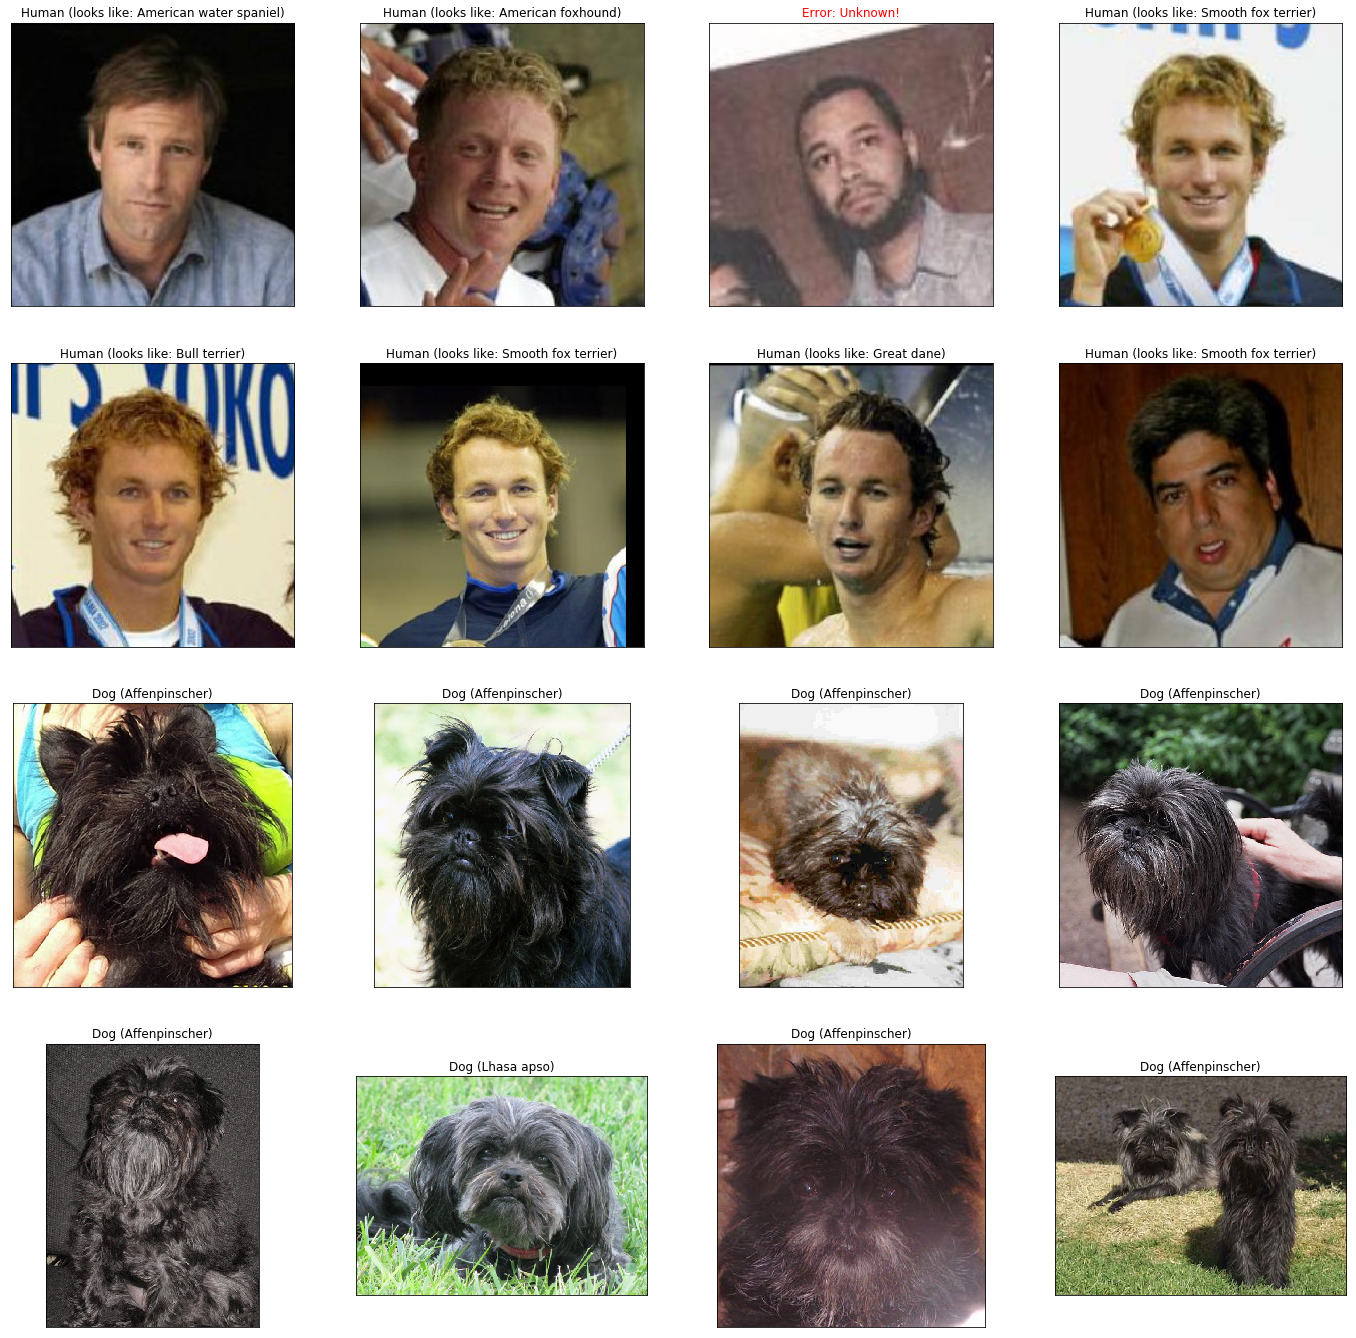

In [39]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# declare auxiliar containers
images, labels = [], []

# apply the app to sample images
for file in np.hstack((human_files[:8], dog_files[:8])):

    # load the image
    images.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

    # classify the image
    labels.append(run_app(file, label_types, model_transfer, device))

# display results
display_image_grid(images, labels, fig_shape=(4, 4), fig_size=(24, 24))